In [1]:
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt
import pandas as pd
import torch

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

log_plot = True

#Note: Need to normalize all values

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def _clean_bounds_values(values, bounds):
    values = np.asarray(values)
    bounds = np.asarray(bounds)
    bounds = bounds.reshape(-1, 2)

    if not (bounds[:, 0] < bounds[:, 1]).all():
        raise ValueError(
            "Lower bound must always be less than the upper bound."
        )

    if bounds.shape[0] == 1:
        values = values.reshape(-1, 1)
    if len(values.shape) == 1:
        values = values.reshape(1, -1)[0]
    else:
        if len(values.shape) != 2 or values.shape[1] != bounds.shape[0]:
            raise ValueError(
                "Shapes of `values` and `bounds` must be consistent. "
                "Please see the doc strings for more information."
            )

    return values, bounds

def values_real_to_scaled(values, bounds):
    """Convert values in physical units to values scaled by bounds
    Parameters
    ----------
    values : array_like, shape=(n,m)
        Input values (unscaled)
    bounds : array_like, shape=(m,2)
        Bounds to scale `values`. Lower bound is 0 and upper bound
        is 1 in `scaled_values`.
    Returns
    -------
    scaled_values : np.ndarray, shape=(n,m)
        The values scaled by `bounds`
    Notes
    -----
    The `bounds` define the 0 and 1 limits of the `scaled_values`.
    The `values` may exceed the bounds; in this case the
    `scaled_values` will have values < 0 or > 1.
    """
    values, bounds = _clean_bounds_values(values, bounds)
    return (values - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])


def values_scaled_to_real(scaled_values, bounds):
    """Convert scaled values to values in physical units
    Parameters
    ----------
    scaled_values : array_like, shape=(n,m)
        Input values (scaled)
    bounds : array_like, shape=(m,2)
        Bounds to scale `values`. Lower bound is 0 and upper bound
        is 1 in `scaled_values`.
    Returns
    -------
    values : np.ndarray, shape=(n,m)
        The values in unscaled units
    Notes
    -----
    The `bounds` define the 0 and 1 limits of the `scaled_values`.
    The `scaled_values` may exceed the 0 and 1; in this case the
    `values` will have values < lower bound or > upper bound.
    """
    scaled_values, bounds = _clean_bounds_values(scaled_values, bounds)
    return scaled_values * (bounds[:, 1] - bounds[:, 0]) + bounds[:, 0]

In [3]:
%%time
# Create synthetic data assuming the following values for theta
a_guess = np.array([0.5,0.5,-7,1])

Constants = np.array([[-200,-100,-170,15],
                      [-1,-1,-6.5,0.7],
                      [0,0,11,0.6],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]])


##New Cell

# Evaluate model and add noise based on assumed theta values
# This generates experimental data points
exp_data_doc = "Input_CSVs/Exp_Data/n=5.csv"
exp_data = pd.read_csv(exp_data_doc, header=0,sep=",",index_col=0)
Num_params  = len(exp_data.T)
Xexp = np.array([exp_data.iloc[:,0:Num_params-1]])[0,:]
Yexp = np.array([exp_data.iloc[:,-1]])[0,:]

#Create Scaled Values
Constant_bounds = np.array([[np.min(Constants[0]), np.max(Constants[0])],
                            [np.min(Constants[1]), np.max(Constants[1])],
                            [np.min(Constants[2]), np.max(Constants[2])],
                            [np.min(Constants[3]), np.max(Constants[3])],
                            [np.min(Constants[4]), np.max(Constants[4])],
                            [np.min(Constants[5]), np.max(Constants[5])]])
a_bounds = np.array([[-2, 0],[-2,0],[-10,2],[-2,2]])
Xexp_bounds = np.array([[-1.5,1],[-0.5,2]])
Yexp_bounds = np.array([[np.min(Yexp),np.max(Yexp)]])

a_guess_scaled = values_real_to_scaled(a_guess, a_bounds)
Xexp_scaled = values_real_to_scaled(Xexp, Xexp_bounds)
Yexp_scaled = values_real_to_scaled(Yexp, Yexp_bounds).T[0]
Constants_scaled = values_real_to_scaled(Constants.T, Constant_bounds).T

CPU times: user 4.3 ms, sys: 1.87 ms, total: 6.17 ms
Wall time: 4.71 ms


In [4]:
print(Yexp_scaled)
print(Yexp)

[0.         0.62182887 0.36341877 1.         0.7023981 ]
[-146.69947812  -80.76773816 -108.16663897  -40.67072465  -72.22508357]


/tmp/ipykernel_2784370/2727746065.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour3D(X1, X2, Y, 50, cmap='Reds', label = "True Model")


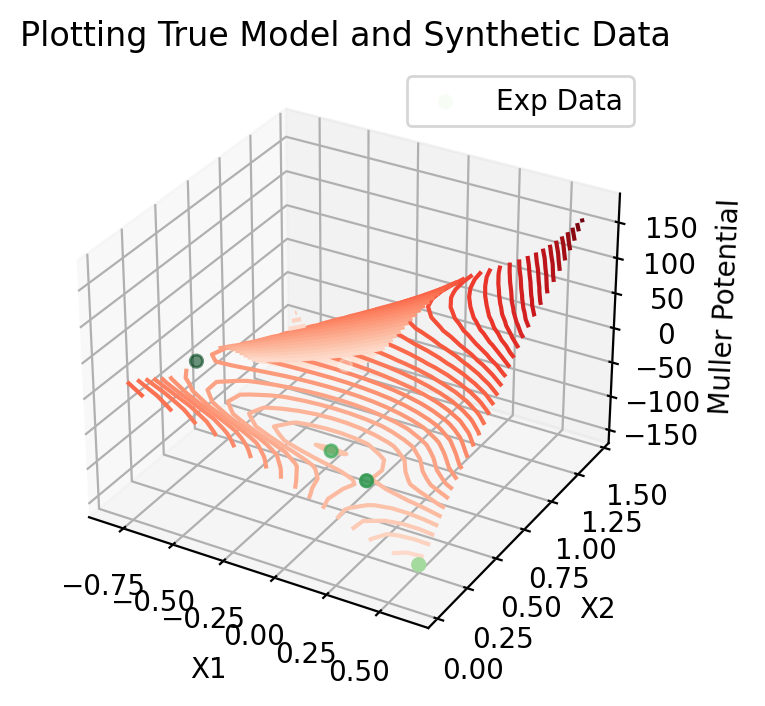

In [5]:
##New Cell

# Evaluate model based on the assumed experimental values
#Create Meshgrid for X1 and X2 and evaluate Y
len_mesh_data = 20
x1 = np.linspace(np.min(Xexp[:,0]),np.max(Xexp[:,0]),len_mesh_data)
x2 = np.linspace(np.min(Xexp[:,1]),np.max(Xexp[:,1]),len_mesh_data)
X1, X2 = np.meshgrid(x1,x2)
X_mesh = np.meshgrid(x1,x2)
# #Creates an array for Y that will be filled with the for loop
# #Initialize y_sim
Y = [] #len_data 

# #Find evey combination of X1/X2 to find the SSE for each combination
#Set constants
A, a, b, c, x0, y0 = Constants

#Calculate y_sim
#Define X1 and X2 (Need a better way do do this without for loops)
#Loop over combinations of X1 X2
for i in range(len_mesh_data):
    for j in range(len_mesh_data):
        Term1 = a*(X1[i,j] - x0)**2
        Term2 = b*(X1[i,j] - x0)*(X2[i,j] - y0)
        Term3 = c*(X2[i,j] - y0)**2
        Y.append( np.sum( A*np.exp(Term1 + Term2 + Term3) ) )
        
#Reshape to correct dimension (Is there an easier wat to do this?)        
Y = np.array(Y).reshape(len_mesh_data,-1)
# print(Y)
# Compare the experiments to the true model
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X1, X2, Y, 50, cmap='Reds', label = "True Model")
ax.scatter3D(Xexp[:,0], Xexp[:,1], Yexp, c=Yexp, cmap='Greens', label = "Exp Data")
ax.legend() #Why won't this show both labels?
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Muller Potential');
plt.title("Plotting True Model and Synthetic Data")
plt.show()

# Y_scaled = np.array(Y_scaled).reshape(len_mesh_data,-1)
# Y_bounds = np.array([np.min(Y_scaled), np.max(Y_scaled)])
# Y = values_scaled_to_real(Y_scaled, Y_bounds)
# Y = Y.reshape(len_mesh_data,-1)

In [6]:
##New Cell

## define function that includes nonlinear model
def model(a_guess, Constants, x):
    '''
        """
    Creates Muller potential values given a guess for "a"
    Parameters
    ----------
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, Independent variable data (exp or pred)
    Returns
    -------
        y_model: ndarray, The simulated Muller potential given the guess
    '''
    #Assert statements check that the types defined in the doctring are satisfied
    
    #Converts parameters to numpy arrays if they are tensors
    if torch.is_tensor(a_guess)==True:
        a_guess = a_guess.numpy()
        
    if isinstance(a_guess, pd.DataFrame):
        a_guess = a_guess.to_numpy()
    
    #Initialize y_sim, set len_data and dim_x
    len_x_shape = len(x.shape) #Will tell us whether we're looking at Xexp or Xmesh
        
    if len_x_shape < 3:
        len_x_data = x.shape[0]
        y_model = np.zeros(len_x_data)
        
    else:
        len_x_data = x.shape[1]
        y_model = np.zeros((len_x_data, len_x_data))

    #Iterates over Xexp to find the y for each combination
    for i in range(len_x_data):
        #Set dig out values of a from train_p
        #Set constants to change the a row to the index of the first loop
        A, a, b, c, x0, y0 = Constants
        len_a = a.shape[0]
        a = a_guess
#         print(a)

        #Calculate y_sim
        if len_x_shape < 3:
            X1, X2 = x[i,0], x[i,1]
            Term1 = a*(X1 - x0)**2
            Term2 = b*(X1 - x0)*(X2 - y0)
            Term3 = c*(X2 - y0)**2
            y_model[i] = np.sum(A*np.exp(Term1 + Term2 + Term3) )
        else:
        #loop over all i and j
            X1, X2 = x
            for i in range(len_x_data):
                for j in range(len_x_data):
                    Term1 = a*(X1[i,j] - x0)**2
                    Term2 = b*(X1[i,j] - x0)*(X2[i,j] - y0)
                    Term3 = c*(X2[i,j] - y0)**2
                    y_model[i,j] = ( np.sum( A*np.exp(Term1 + Term2 + Term3) ) )
   
    if not len_x_shape < 3:
        y_model = y_model.reshape(len_x_data, -1)
    
    return y_model

# print(model(a_guess,Constants,Xexp))

##New Cell

# Create a function to optimize, in this case, least squares fitting
def regression_func(a_guess, Constants, x, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    
    error = y - model(a_guess, Constants, x); #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

# print(regression_func(a_guess, Constants, Xexp, Yexp))


In [7]:

## specify initial guess
a0 = a_guess
#Define # of dimensions
try:
    d = a_guess.shape[0]*a_guess.shape[1]
except:
    d = a_guess.shape[0]
## specify bounds
# first array: lower bounds
# second array: upper bounds
lower = np.repeat(-np.inf, d)
upper = np.repeat(np.inf, d)
bounds = (lower, upper) 

## use least squares optimizer in scipy
# argument 1: function that takes theta as input, returns residual
# argument 2: initial guess for theta
# optional arguments 'bounds': bounds for theta
# optional arugment 'args': additional arguments to pass to residual function
# optional argument 'method': select the numerical method
#   if you want to consider bounds, choose 'trf'
#   if you do not want to consider bounds, try either 'lm' or 'trf'
Solution = optimize.least_squares(regression_func, a0 ,bounds=bounds, method='trf',args=(Constants, Xexp, Yexp),verbose=2)

a_model = Solution.x
print("a = ",a_model)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.1877e+03                                    1.12e+04    
       1              2         1.3465e+03      5.84e+03       2.39e+00       2.84e+03    
       2              3         6.2180e+01      1.28e+03       1.57e+00       3.80e+02    
       3              4         4.1284e-01      6.18e+01       4.74e-01       3.19e+01    
       4              5         3.1066e-05      4.13e-01       3.78e-02       2.31e-01    
       5              6         2.4936e-11      3.11e-05       2.75e-04       2.00e-05    
       6              7         2.4710e-11      2.26e-13       2.28e-08       5.12e-12    
`gtol` termination condition is satisfied.
Function evaluations 7, initial cost 7.1877e+03, final cost 2.4710e-11, first-order optimality 5.12e-12.
a =  [-1.00000054 -0.99999948 -6.50002018  0.7       ]


In [8]:
def sse_func(a_model, x, y, P_inds, P1_vals, P2_vals):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all a_1 values
        yy: An D X N array of all a_2 values
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    #Meshgrid
    P1_mesh, P2_mesh = np.meshgrid(P1_vals,P2_vals)
    #Copy Center Point
    a_guess_local = np.copy(a_model)
    
    #Initialize SSE Maxtrix
    sse = np.zeros((len(P1_mesh),len(P2_mesh)))
    
    #Calculate SSE
    for i in range(len(P1_mesh)):
        for j in range(len(P2_mesh)):
            a_guess_local[P_inds[0]] = P1_mesh[i,j]
            a_guess_local[P_inds[1]] = P2_mesh[i,j]
#             print(a_guess_local)
            sse[i,j] = sum((y - model(a_guess_local, Constants, x))**2) 
    
    return sse

In [9]:
# a1, a2, a3, a4 = np.meshgrid(a1_lin, a2_lin, a3_lin, a4_lin)
# a_guesses = np.meshgrid(a1_lin, a2_lin, a3_lin, a4_lin)

# P_inds = np.array([0,3])
# print(sse_func(a_model, Xexp, Yexp, P_inds, a1_lin, a2_lin))

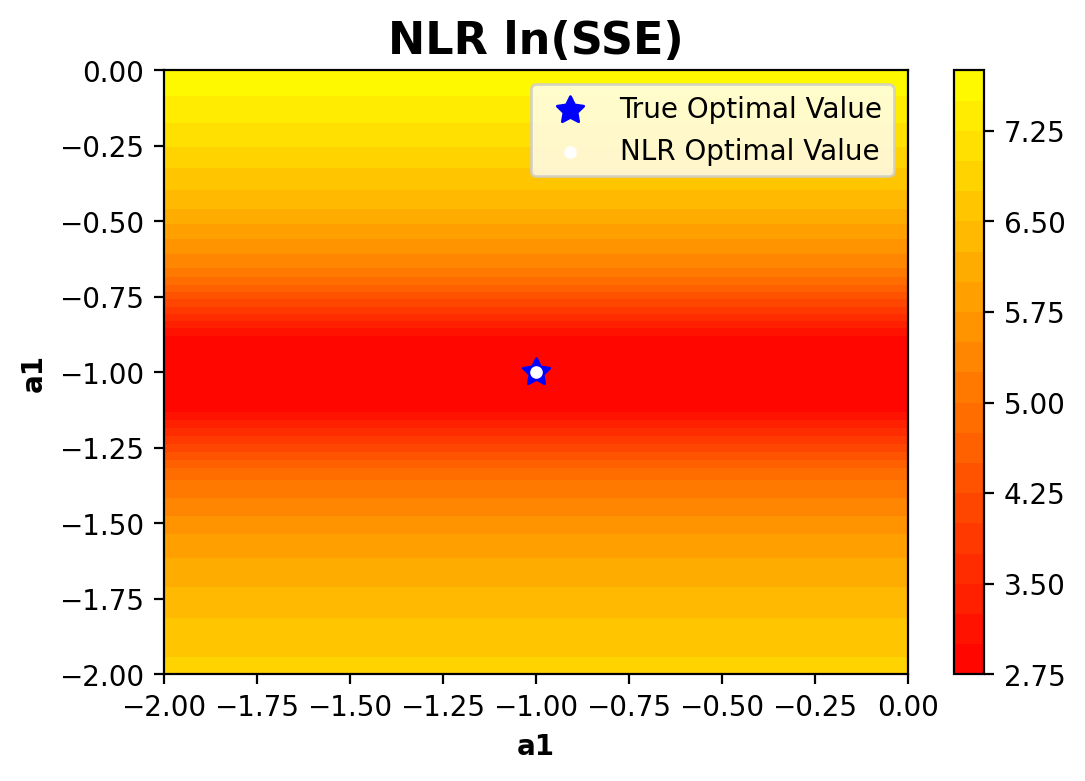

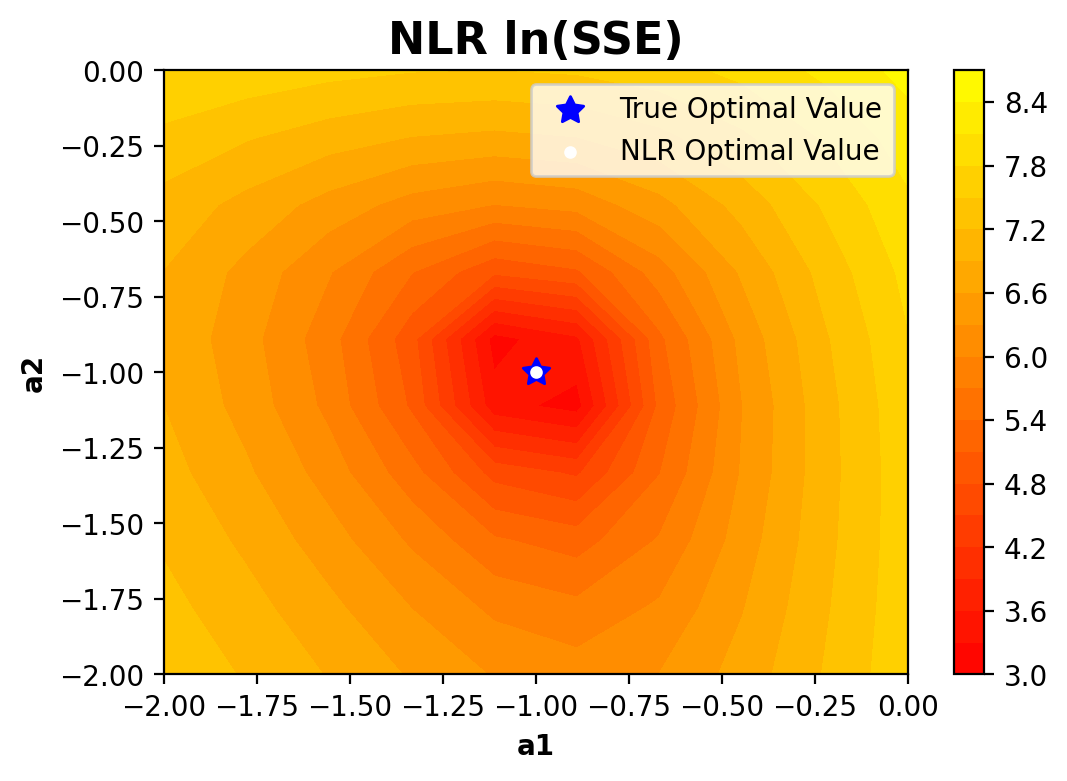

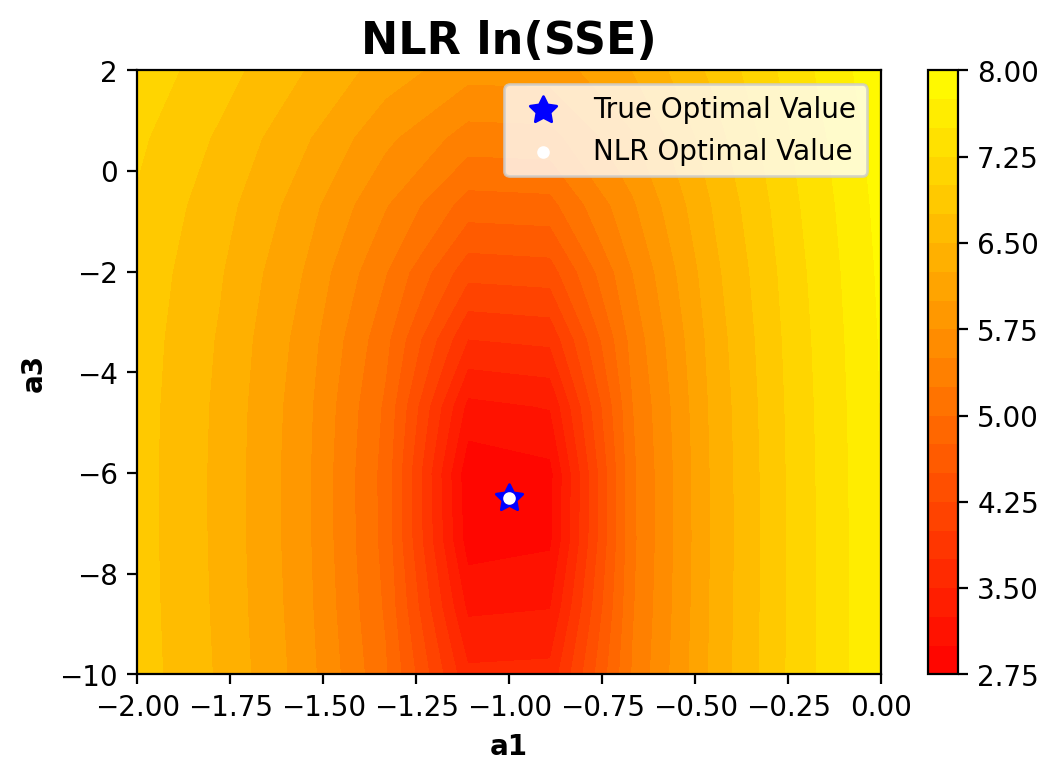

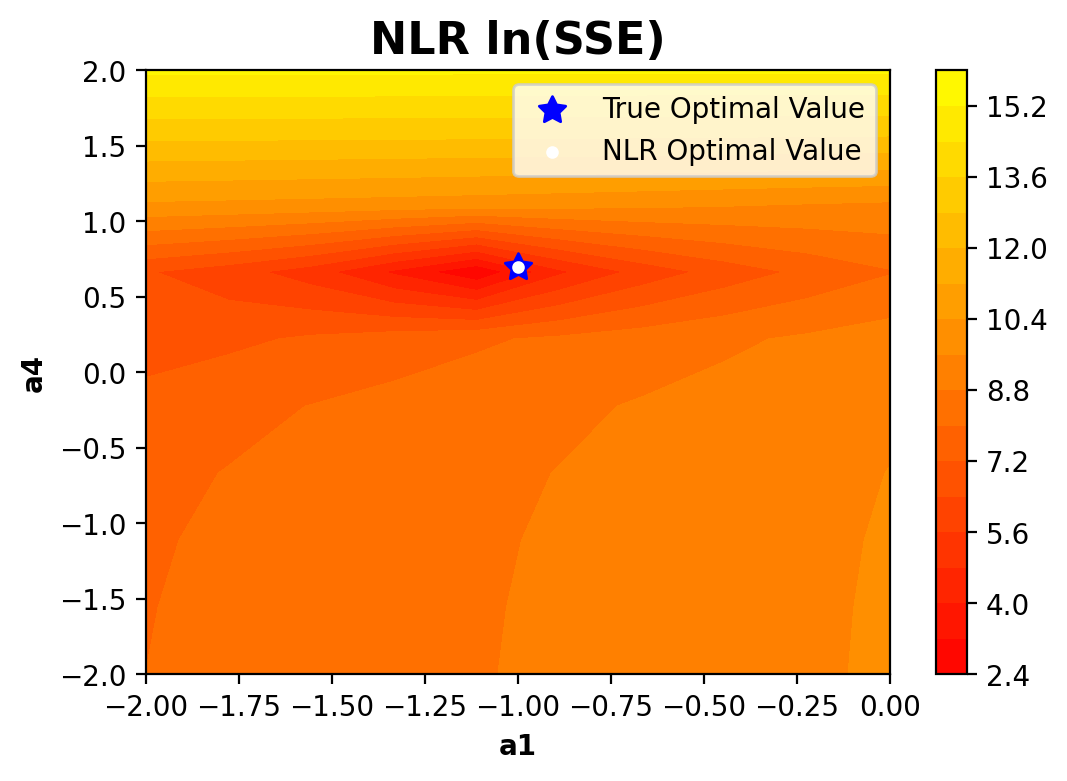

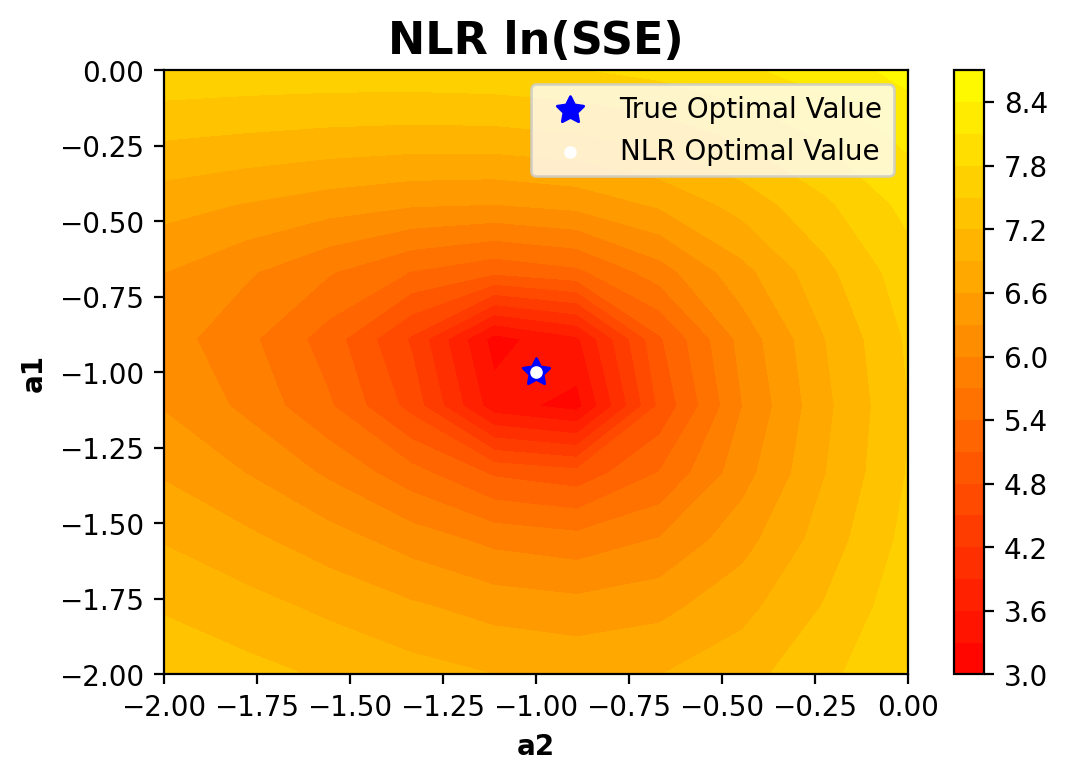

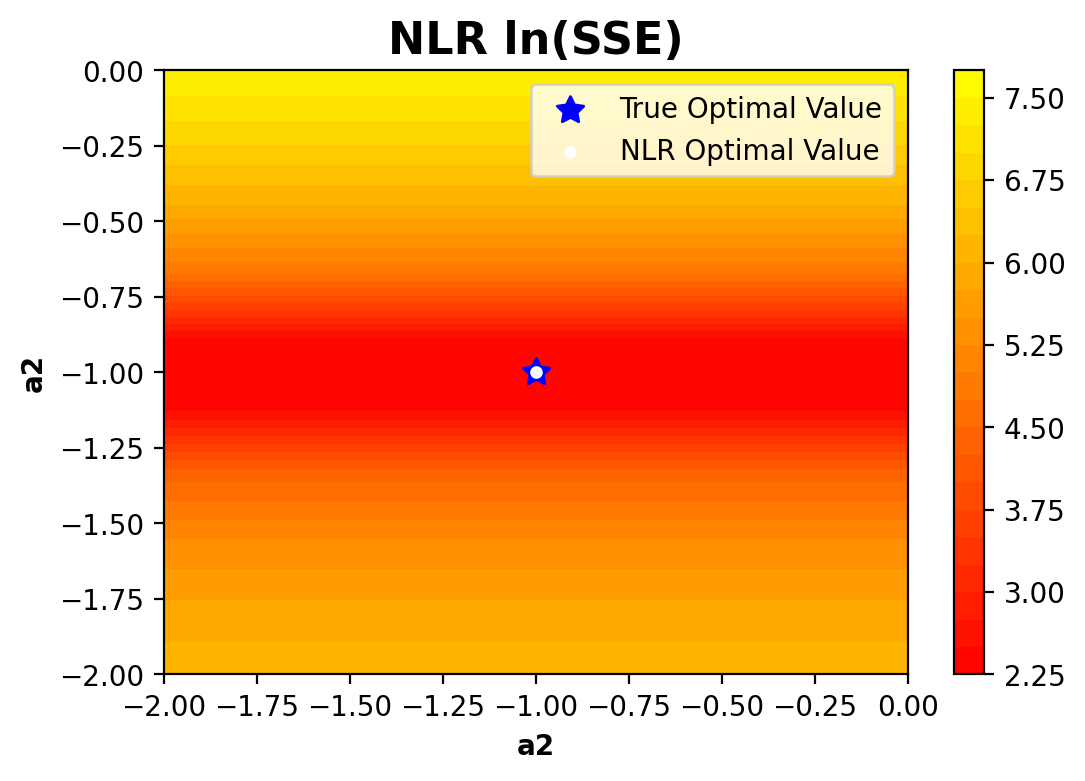

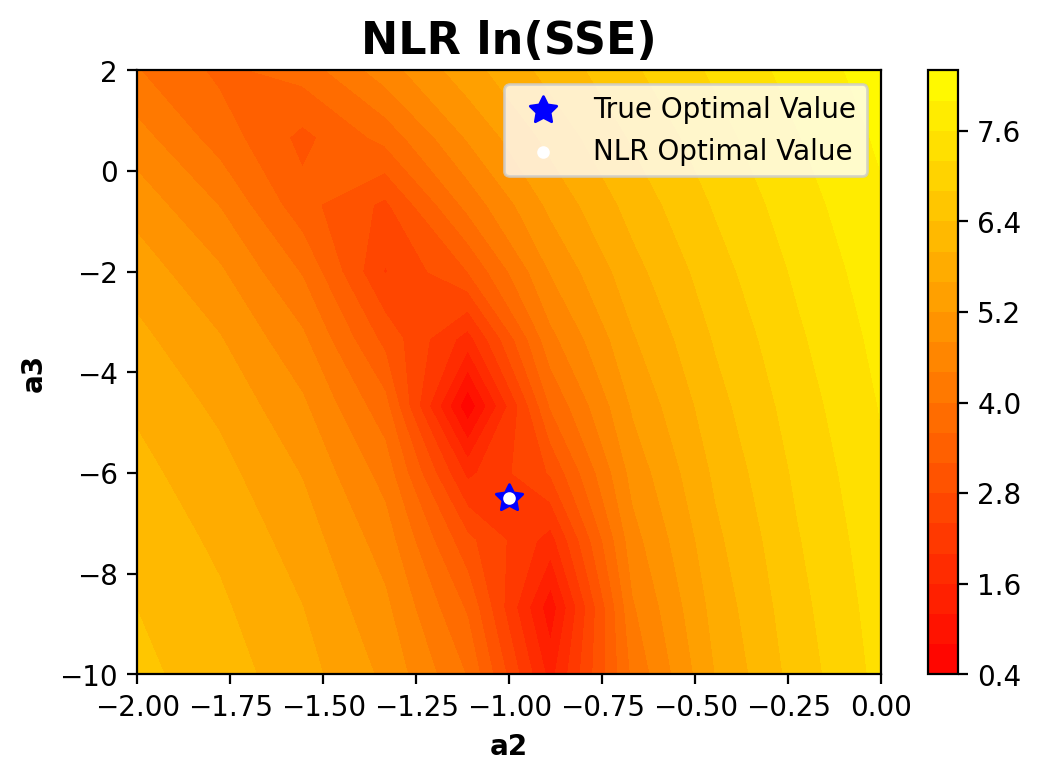

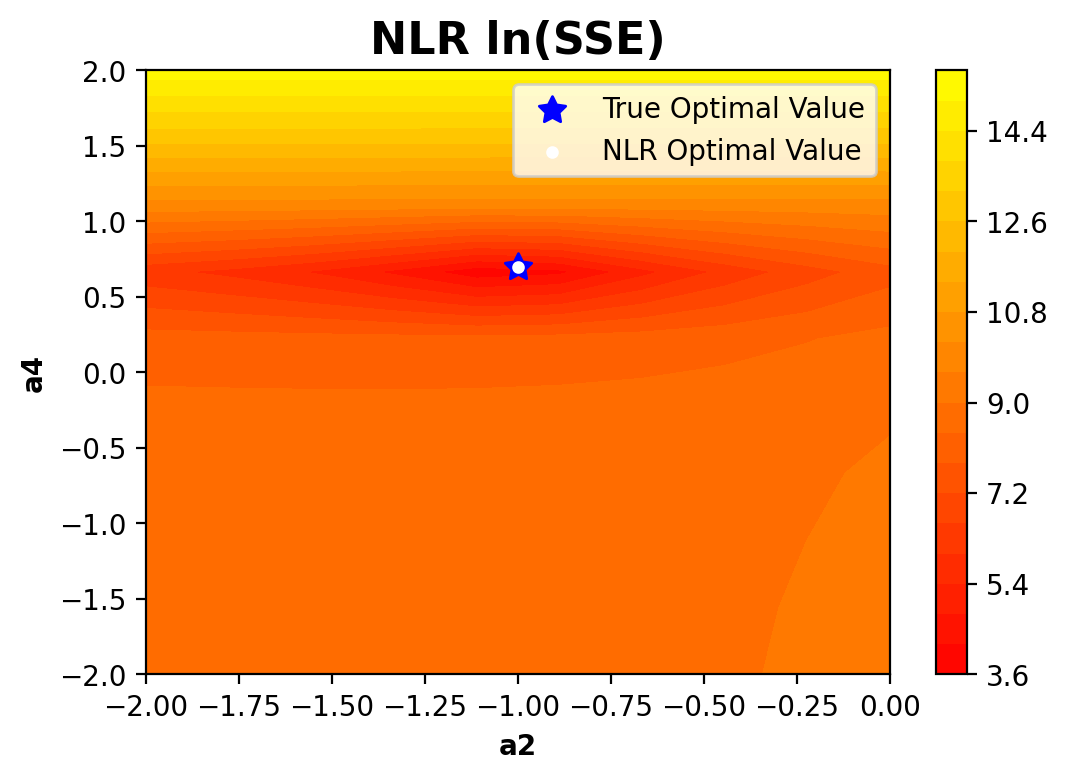

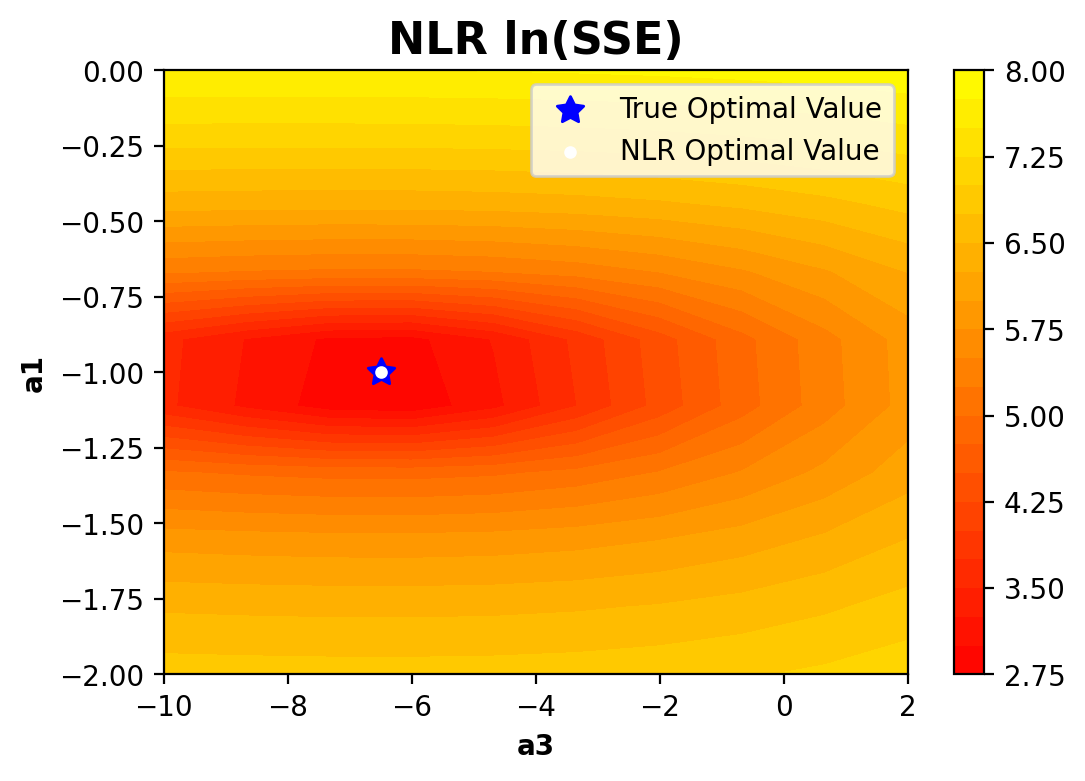

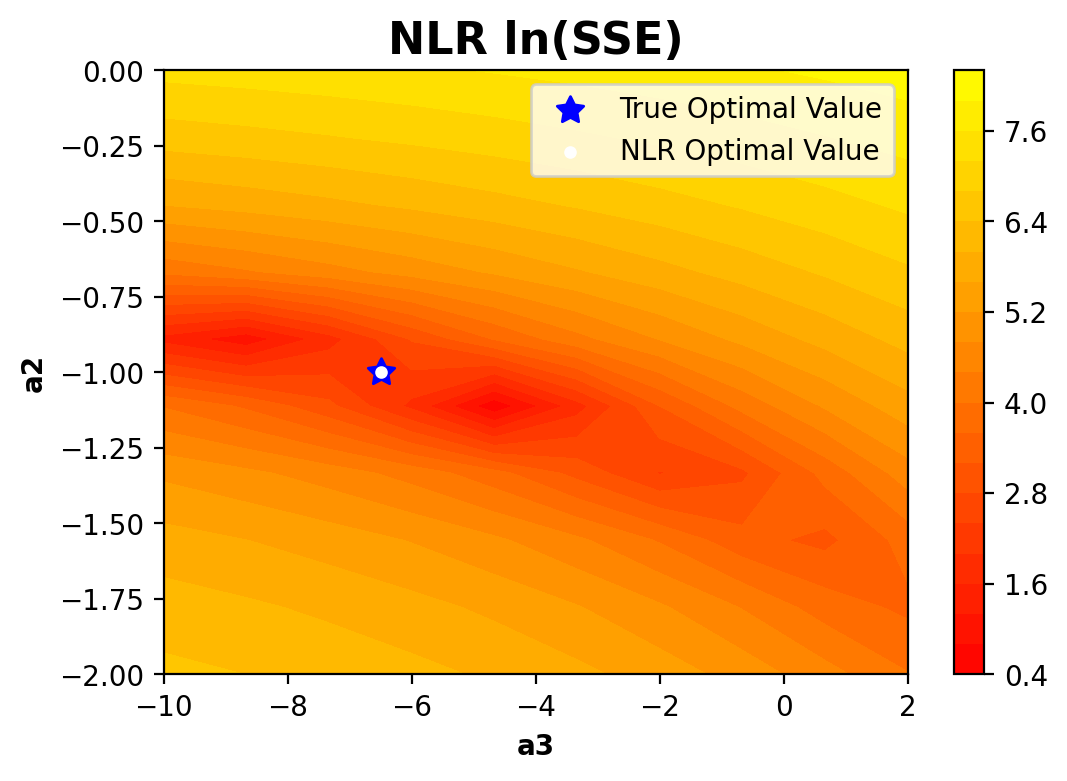

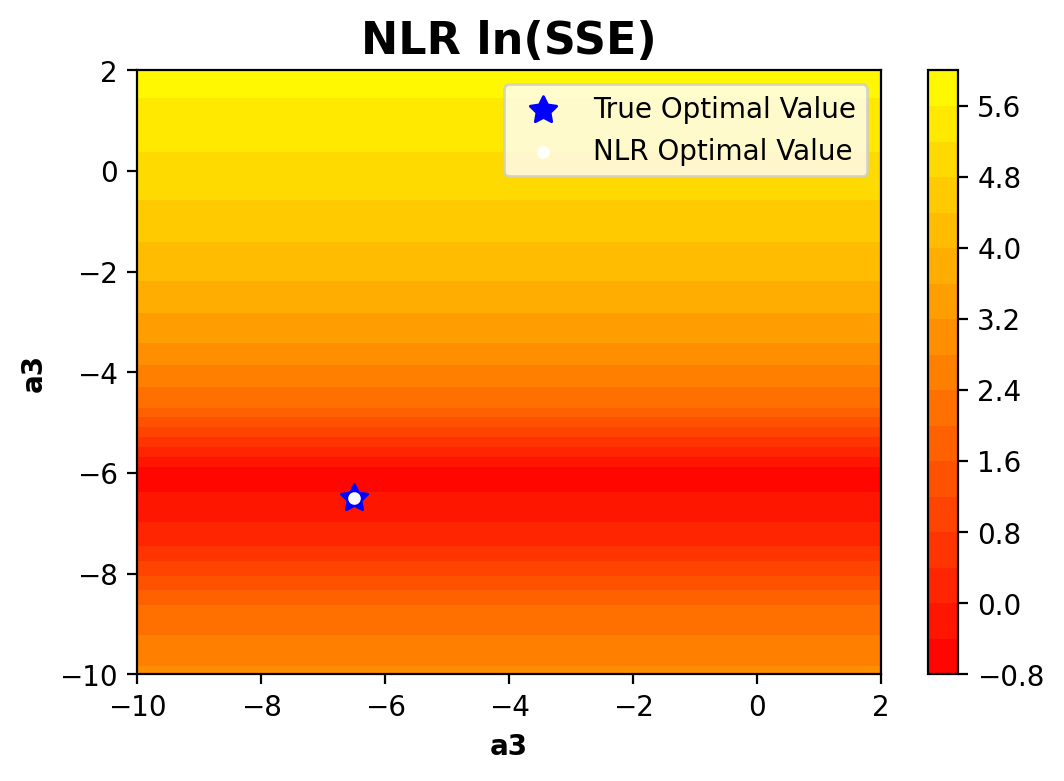

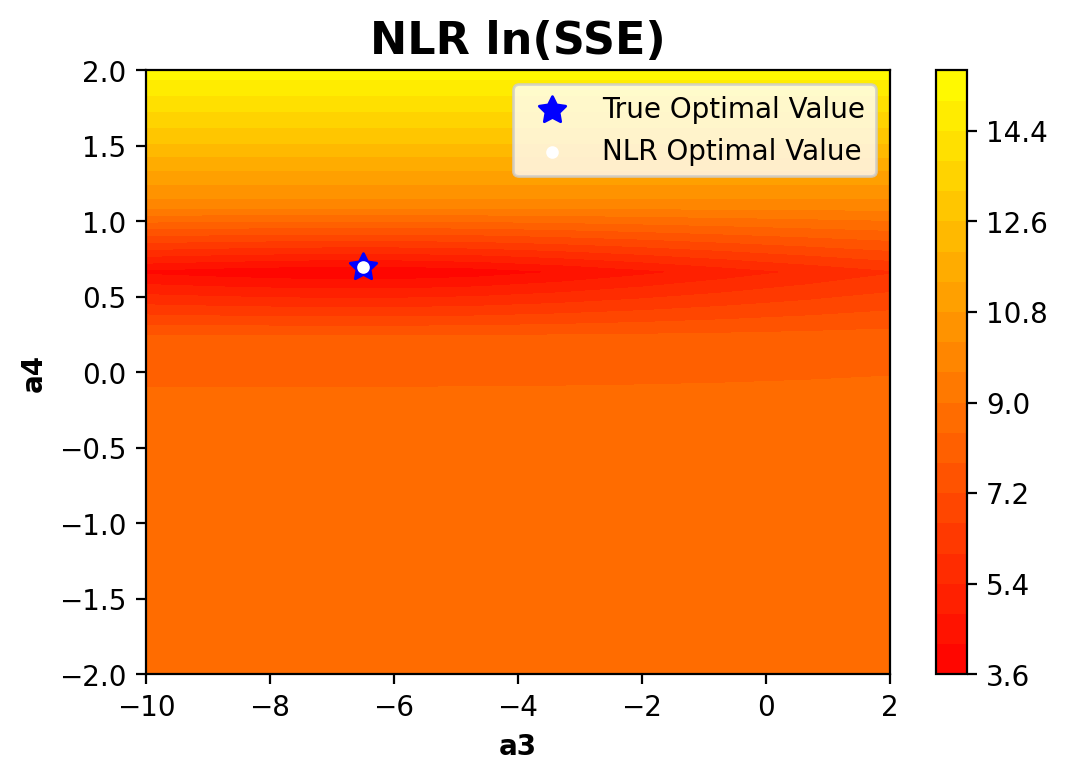

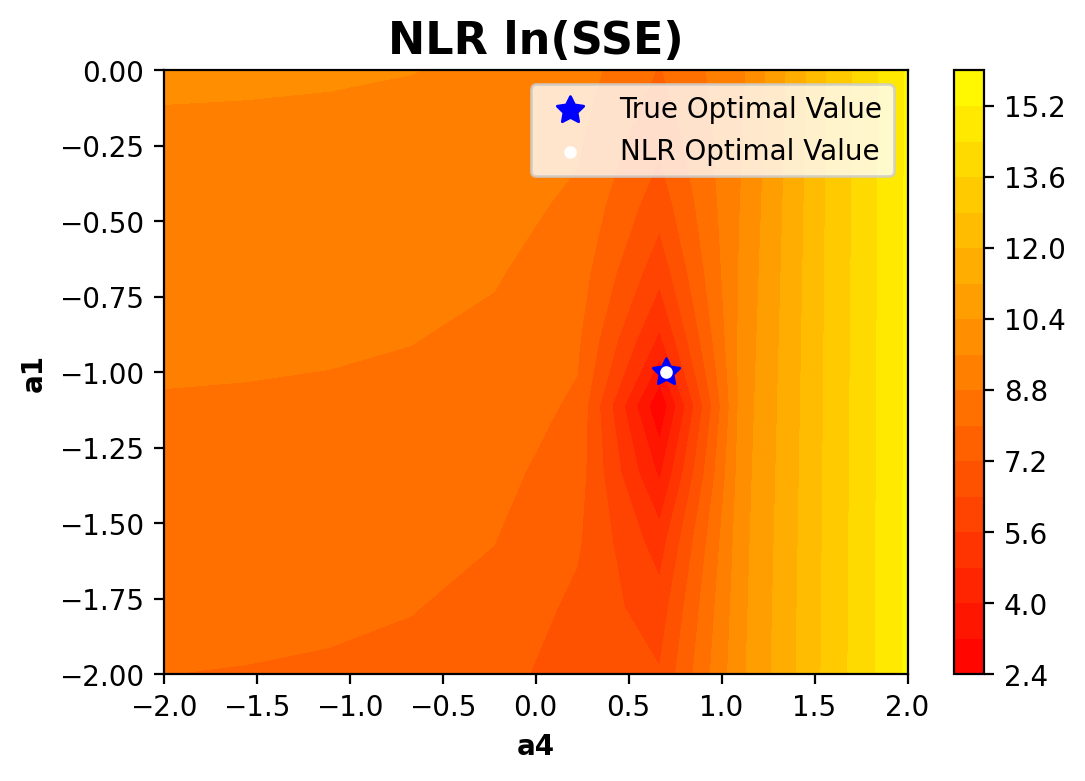

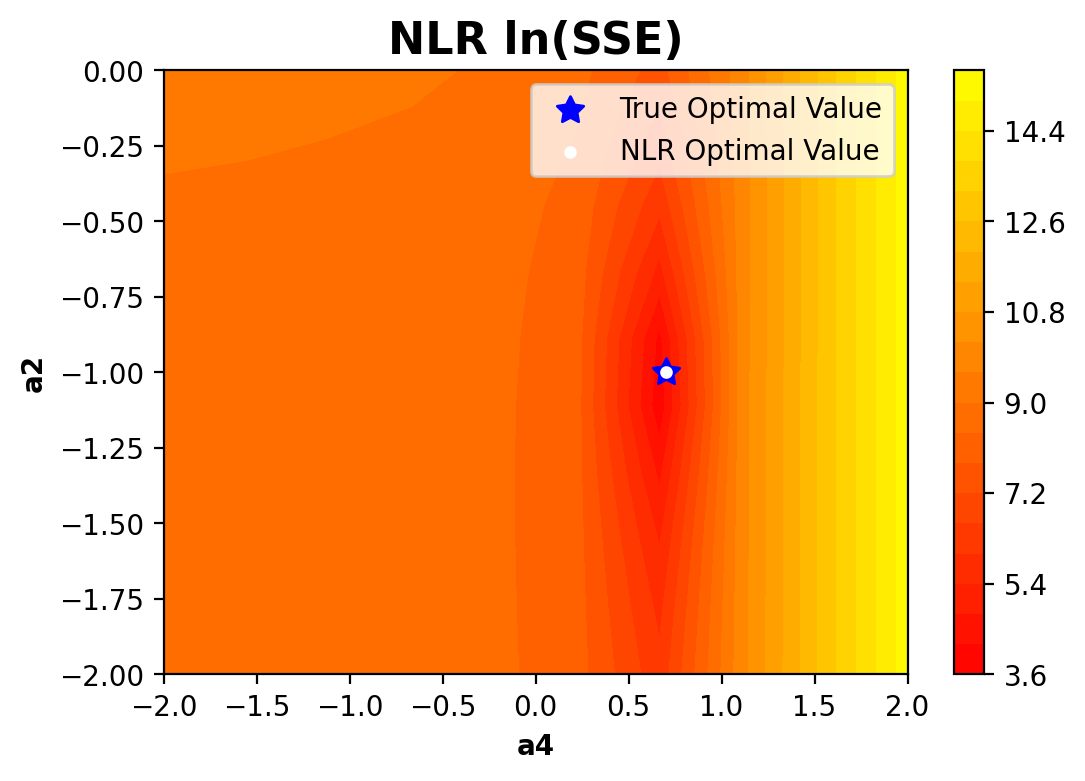

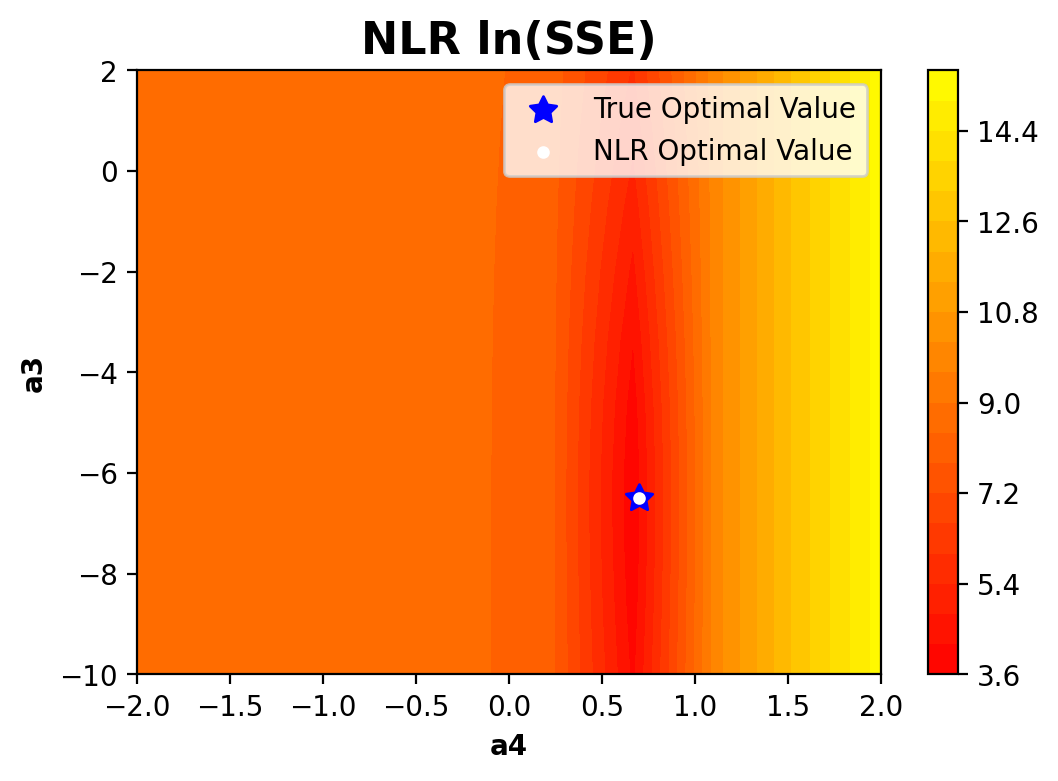

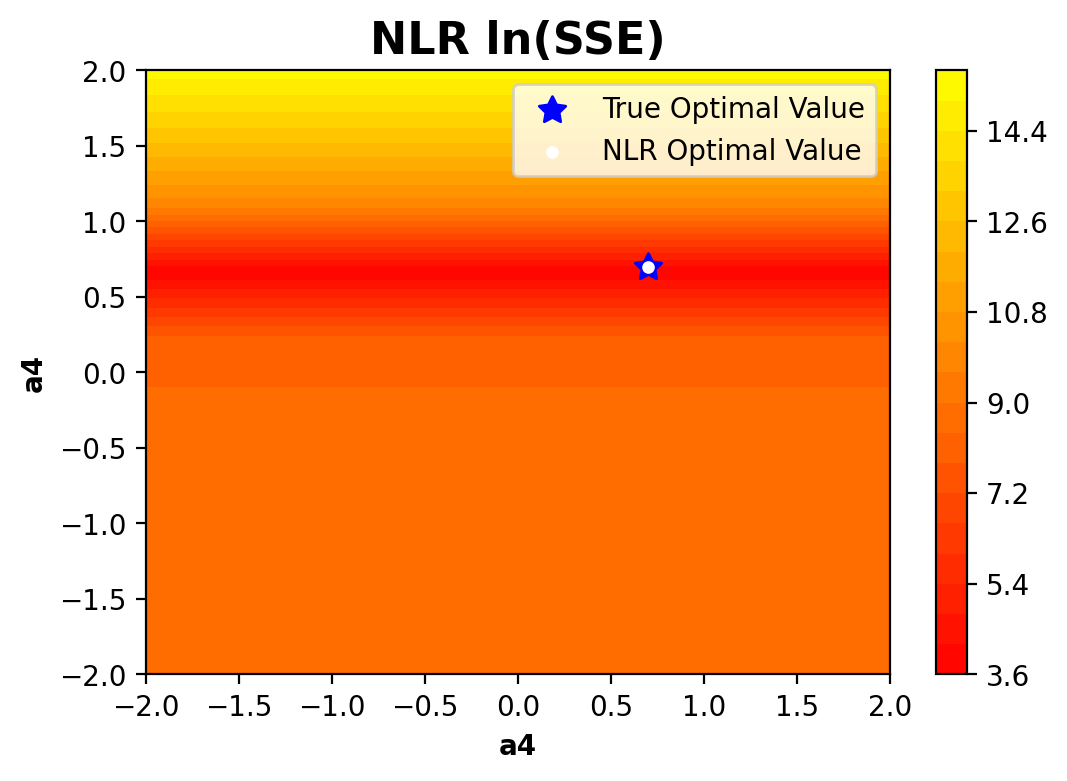

In [10]:
#New Cell
log_plot = True

# generate predictions
X1_pred, X2_pred = np.meshgrid(x1,x2)
X_pred = np.array(np.meshgrid(x1,x2))
Y_pred = model(a_guess, Constants, X_pred)

#Generate Guesses for a1-a4
a1_lin = np.linspace(-2,0,10)
a2_lin = np.linspace(-2,0,10)
a3_lin = np.linspace(-10,2,10)
a4_lin = np.linspace(-2,2,10)

axis_list = [a1_lin, a2_lin, a3_lin, a4_lin]
axis_label_list = ["a1", "a2", "a3", "a4"]


#Loop over combinations of axes and create heatmaps
#How to do this with a for loop?
for i in range(len(a_model)):
    for j in range(len(a_model)):
        P_inds = np.array([i,j])
        P1_vals = axis_list[P_inds[0]]
        P2_vals = axis_list[P_inds[1]]
        #Use a_guesses to create heat map
        zz = sse_func(a_model, Xexp, Yexp, P_inds, P1_vals, P2_vals)

        if log_plot == True:
            zz = np.log(zz)
        #Better way to do this?
        plt.contourf(P1_vals,P2_vals, zz, cmap = "autumn", levels = 20)
        plt.colorbar()
        plt.axis()
        plt.scatter(Constants[1][P_inds[0]],Constants[1][P_inds[1]], color="blue", s=100, label = "True Optimal Value", marker = (5,1))
        plt.scatter(a_model[P_inds[0]],a_model[P_inds[1]], color="white",s=50, marker = ".",label = "NLR Optimal Value")
        # plt.grid()
        plt.legend(loc = 'best')
        plt.xlabel(axis_label_list[P_inds[0]],weight='bold')
        plt.ylabel(axis_label_list[P_inds[1]],weight='bold')
        plt.xlim((np.amin(P1_vals), np.amax(P1_vals)))
        plt.ylim((np.amin(P2_vals),np.amax(P2_vals)))

        if log_plot == True:
            plt.title('NLR ln(SSE)', weight='bold',fontsize = 16)
#             plt.savefig("Figures/NLR_ln(SSE).png",dpi=300)
        else:
            plt.title('Non-Linear Regression SSE', weight='bold',fontsize = 16)
#             plt.savefig("Figures/NLR_SSE.png",dpi=300)

        plt.show()

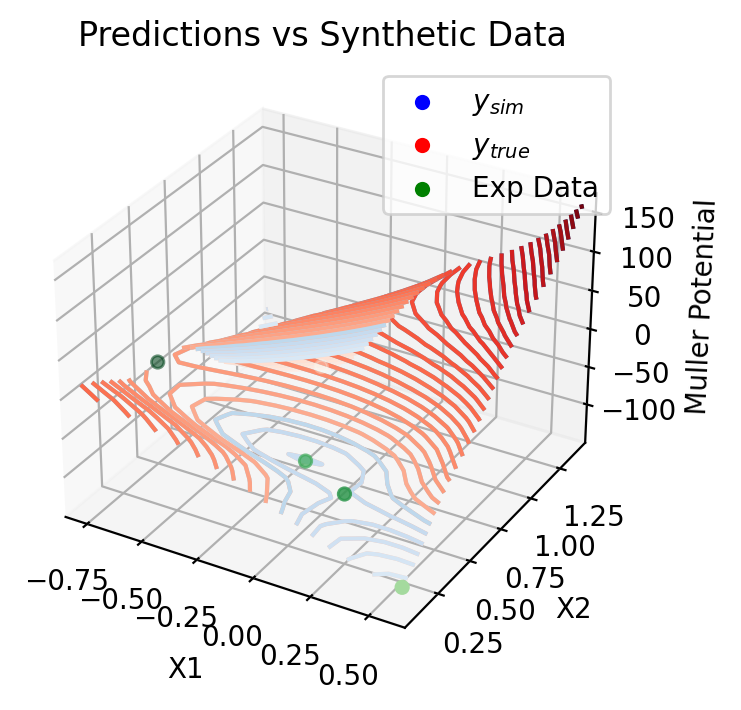

In [11]:
#New Cell
X_pred = np.array(np.meshgrid(x1,x2))
Y_pred = model(a_model, Constants, X_pred)


# create plot and compare predictions and experiments
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X1, X2, Y_pred, 50, cmap='Blues')
ax.contour3D(X1, X2, Y, 50, cmap='Reds')
ax.scatter3D(Xexp[:,0], Xexp[:,1], Yexp, c=Yexp, cmap='Greens')
ax.scatter(1000,1000,1000, label = "$y_{sim}$", color = 'blue')
ax.scatter(1000,1000,1000, label = "$y_{true}$", color = 'red')
ax.scatter(1000,1000,1000, label = "Exp Data", color = 'green')
plt.legend(loc = 'best')
ax.set_zlim(np.amin(Y),np.amax(Y))
ax.set_xlim(np.amin(X1),np.amax(X1))
ax.set_ylim(np.amin(X2),np.amax(X2))
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Muller Potential');
plt.title("Predictions vs Synthetic Data")
plt.show()

# plt.savefig("Figures/sim_true_comp.png",dpi=300)
# plt.show()

SSE =  4.9420986311844644e-11


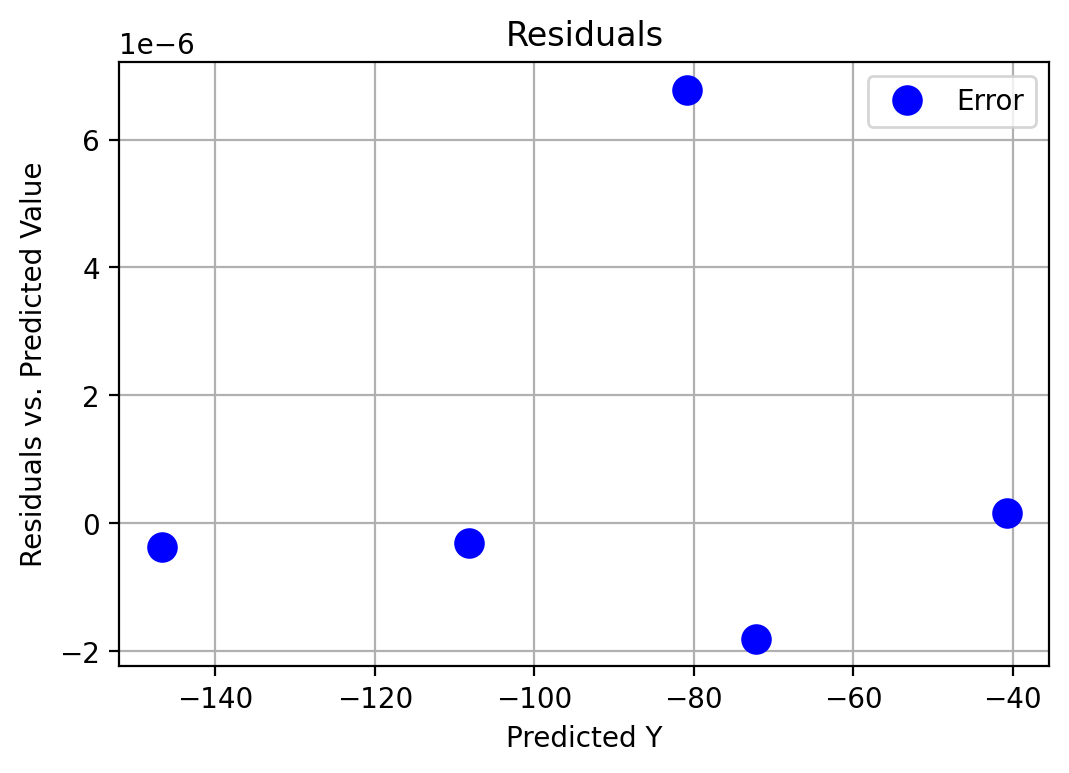

In [12]:
#Plot error
Y_pred_of_exp = model(a_model, Constants, Xexp)
error = (Yexp - Y_pred_of_exp)
print("SSE = ", np.sum(error**2))
plt.plot(Y_pred_of_exp,error,"b.",markersize=20, label = "Error")
plt.title("Residuals")
plt.xlabel('Predicted Y')
plt.ylabel('Residuals vs. Predicted Value')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
#Jacobian and Uncertainty Analysis
print("Jacobian =\n")
print(Solution.jac)
sigre = (error.T @ error)/(len(error) - 2)
Sigma_theta2 = sigre * np.linalg.inv(Solution.jac.T @ Solution.jac)
print("Covariance matrix:\n",Sigma_theta2)

Jacobian =

[[-0.00000000e+00  3.19290161e-03  5.68045391e-01 -4.33138657e+00]
 [ 8.26894603e+00  2.46674538e-01  5.39924704e-05 -2.29258690e+01]
 [ 2.44670679e+01  2.83710289e+00 -0.00000000e+00 -1.87786992e+02]
 [ 5.16638955e-01  2.97214398e+01  1.29088470e+00 -5.27911663e-01]
 [ 2.69233597e+01  3.09106255e+00 -0.00000000e+00 -5.34224968e+01]]
Covariance matrix:
 [[ 4.41541222e-14 -1.50908980e-14  2.87110819e-13  6.84922247e-15]
 [-1.50908980e-14  1.15219411e-13 -2.21824543e-12 -4.65727090e-16]
 [ 2.87110819e-13 -2.21824543e-12  5.09899381e-11  9.08857900e-15]
 [ 6.84922247e-15 -4.65727090e-16  9.08857900e-15  1.52054851e-15]]


In [14]:
import scipy.linalg as linalg
val, vec = linalg.eig(Sigma_theta2)
print(val)
print(vec)

[5.10880960e-11+0.j 4.38944676e-14+0.j 4.15078341e-16+0.j
 1.84266228e-14+0.j]
[[-5.63224737e-03  9.82236744e-01  1.60440942e-01  9.71491713e-02]
 [ 4.34779790e-02 -1.01141700e-01  1.90036951e-02  9.93739846e-01]
 [-9.99038493e-01 -9.96743829e-03  9.92303288e-05  4.26934327e-02]
 [-1.78885854e-04  1.57740249e-01 -9.86862480e-01  3.49346244e-02]]
